# Phase 3 Classification Project — End-to-End ML Pipeline

## Project Goal
This project builds an end-to-end **classification** machine learning solution using an iterative modeling approach.  
I will train models on historical survey responses and predict the probability that a respondent received:

- **H1N1 vaccine** (`h1n1_vaccine`)
- **Seasonal flu vaccine** (`seasonal_vaccine`)

Accurate predictions can help public health teams identify groups with lower vaccination likelihood and target communication, access, and outreach efforts more effectively.

## Deliverables
1. A full Jupyter notebook (EDA → preprocessing → modeling → evaluation → predictions)
2. A non-technical presentation for stakeholders
3. A GitHub README summarizing the work


In [4]:
#importing libraries
import pandas as pd
import numpy as np

#reading into the csv files
train_X = pd.read_csv("training_set_features.csv")
train_y = pd.read_csv("training_set_labels.csv")
test_X  = pd.read_csv("test_set_features.csv")
sub_fmt = pd.read_csv("submission_format.csv")

print("train_X:", train_X.shape)
print("train_y:", train_y.shape)
print("test_X :", test_X.shape)
print("sub_fmt:", sub_fmt.shape)

#checking the first 5 rows
train_X.head()


train_X: (26707, 36)
train_y: (26707, 3)
test_X : (26708, 36)
sub_fmt: (26708, 3)


,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb


## 2. Data Understanding (EDA)

### What we are checking in EDA
Before modeling, we need to understand:

1. **Data structure** (rows/columns and how files relate)
2. **Targets** (class balance and whether the problem is classification)
3. **Feature types** (numeric vs categorical)
4. **Missingness patterns** (what needs imputation)
5. **Early relationships** (simple patterns that can guide modeling choices)



### Two Targets → Multi-output Binary Classification

We are predicting **two binary outcomes** for the same respondent:
- `h1n1_vaccine` (0/1)
- `seasonal_vaccine` (0/1)

This is best treated as **multi-output binary classification**:
- each target is a separate binary classification task
- the model outputs two probabilities per respondent (one per target)

This matches the submission format which requires:
- `h1n1_vaccine` probability
- `seasonal_vaccine` probability


In [5]:
# Setting respondent_id as index to align safely
X = train_X.set_index("respondent_id")
y = train_y.set_index("respondent_id")[["h1n1_vaccine", "seasonal_vaccine"]]

print("X aligned with y:", X.shape, y.shape)
print("Any missing respondent_id alignment?", (X.index.equals(y.index)))

# Target rates
print("Target prevalence (mean):")
display(y.mean().to_frame("positive_rate"))

# Joint distribution 
display(y.value_counts().rename("count").to_frame().head(10))


X aligned with y: (26707, 35) (26707, 2)
Any missing respondent_id alignment? True
Target prevalence (mean):


,positive_rate
h1n1_vaccine,0.212454
seasonal_vaccine,0.465608


count
h1n1_vaccine seasonal_vaccine       
0            0                 13295
             1                  7738
1            1                  4697
             0                   977

In [6]:
cat_cols = X.select_dtypes(include="object").columns.tolist()
num_cols = [c for c in X.columns if c not in cat_cols]

print("Categorical columns:", len(cat_cols))
print(cat_cols)

print("\nNumeric columns:", len(num_cols))
print(num_cols[:10], "...")


Categorical columns: 12
['age_group', 'education', 'race', 'sex', 'income_poverty', 'marital_status', 'rent_or_own', 'employment_status', 'hhs_geo_region', 'census_msa', 'employment_industry', 'employment_occupation']

Numeric columns: 23
['h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds', 'behavioral_avoidance', 'behavioral_face_mask', 'behavioral_wash_hands', 'behavioral_large_gatherings', 'behavioral_outside_home', 'behavioral_touch_face', 'doctor_recc_h1n1'] ...


### Missing Values (Why we must handle them carefully)

Many real-world survey datasets have missing responses.  
We measure missingness per feature because it impacts model training.

Key principle:
- We must handle missing values **inside a modeling pipeline** (using imputation steps)
- This prevents **data leakage** because imputation statistics must be learned only from training folds during cross-validation.

We will use strategies like:
- Most frequent value imputation for categorical fields
- Median imputation for numeric fields


,missing_rate
employment_occupation,0.504362
employment_industry,0.499120
health_insurance,0.459580
income_poverty,0.165612
doctor_recc_h1n1,0.080878
doctor_recc_seasonal,0.080878
rent_or_own,0.076459
employment_status,0.054780
marital_status,0.052720
education,0.052683


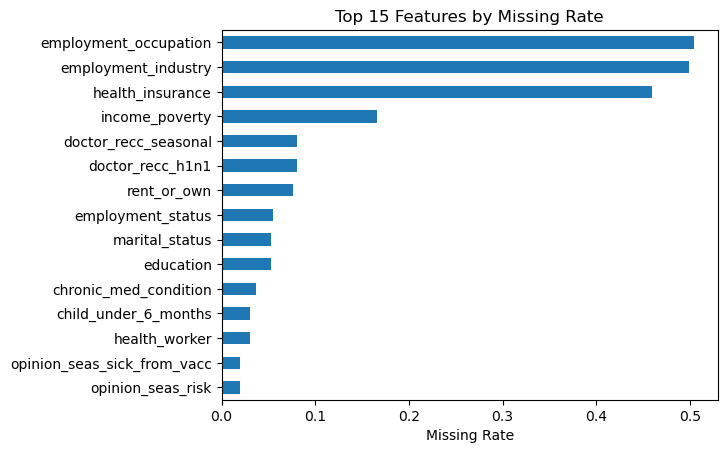

In [7]:
missing_rate = X.isna().mean().sort_values(ascending=False)
display(missing_rate.head(15).to_frame("missing_rate"))

# Optional: visualize top missing columns
import matplotlib.pyplot as plt

top_k = 15
plt.figure()
missing_rate.head(top_k).sort_values().plot(kind="barh")
plt.title(f"Top {top_k} Features by Missing Rate")
plt.xlabel("Missing Rate")
plt.show()


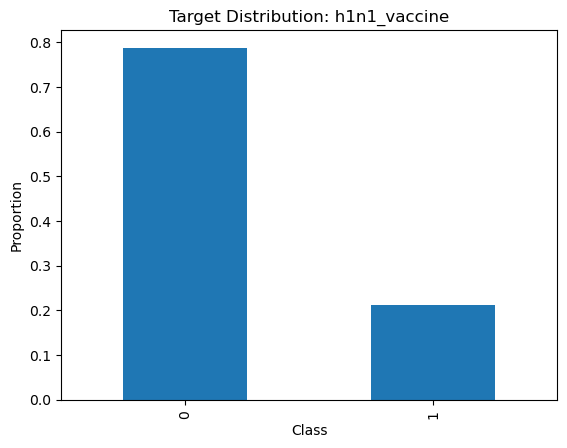

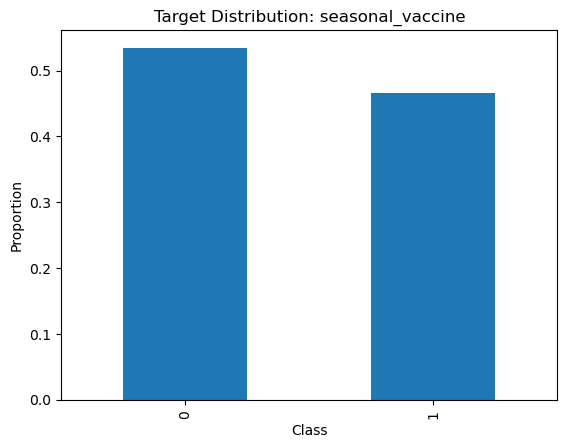

In [8]:
import matplotlib.pyplot as plt

plt.figure()
y["h1n1_vaccine"].value_counts(normalize=True).sort_index().plot(kind="bar")
plt.title("Target Distribution: h1n1_vaccine")
plt.xlabel("Class")
plt.ylabel("Proportion")
plt.show()

plt.figure()
y["seasonal_vaccine"].value_counts(normalize=True).sort_index().plot(kind="bar")
plt.title("Target Distribution: seasonal_vaccine")
plt.xlabel("Class")
plt.ylabel("Proportion")
plt.show()


In [10]:
# Example: mean target rate by a categorical feature (age_group)
tmp = X.join(y)

age_summary = tmp.groupby("age_group")[["h1n1_vaccine", "seasonal_vaccine"]].mean().sort_index()
display(age_summary)

# Example: mean target rate by health_worker (numeric indicator)
hw_summary = tmp.groupby("health_worker")[["h1n1_vaccine", "seasonal_vaccine"]].mean()
display(hw_summary)


,h1n1_vaccine,seasonal_vaccine
age_group,,
18 - 34 Years,0.190029,0.284564
35 - 44 Years,0.197765,0.362526
45 - 54 Years,0.194731,0.401298
55 - 64 Years,0.242855,0.511235
65+ Years,0.226655,0.673681


,h1n1_vaccine,seasonal_vaccine
health_worker,,
0.0,0.188793,0.445618
1.0,0.409452,0.647120


## EDA Summary 

From this dataset we observed:
- The task is **classification** with **two binary targets**
- `h1n1_vaccine` appears more imbalanced than `seasonal_vaccine`
- The dataset contains a mix of numeric and categorical features
- Several columns have substantial missingness (especially employment-related features)

Next, we will:
1. Split the data into train/validation sets (carefully, to maintain target distributions)
2. Build a preprocessing pipeline with:
   - imputation for missing values
   - one-hot encoding for categorical columns
   - scaling for numeric columns (where needed)
3. Train baseline and improved models and compare performance using classification metrics


# 3. Data Preparation & Preprocessing

After understanding the data, we now prepare it for modeling.

This step is critical because:
- Models cannot handle missing values or raw categorical text
- Data leakage must be avoided
- Transformations must be applied consistently to train and test data

We follow professional ML best practices:
1. Train/validation split
2. Separate numeric and categorical preprocessing
3. Use pipelines to prevent leakage
4. Prepare features for multiple models


## Why split BEFORE preprocessing?

To avoid **data leakage**, we must split the data first.

Data leakage occurs when:
- statistics from validation/test data influence training transformations
- for example, scaling using the entire dataset mean

This causes overly optimistic results.

Correct approach:
1. Split data
2. Fit preprocessing only on training data
3. Apply learned transforms to validation/test


In [11]:
from sklearn.model_selection import train_test_split

# We stratify using both targets together to preserve class distribution
# Create combined label string for safe stratification
stratify_labels = y.astype(str).agg("-".join, axis=1)

X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=stratify_labels
)

print("Train shape:", X_train.shape)
print("Validation shape:", X_val.shape)


Train shape: (21365, 35)
Validation shape: (5342, 35)


### Why stratify?

Our targets are imbalanced, especially `h1n1_vaccine`.

If we split randomly:
- validation might have fewer positive examples
- metrics become unreliable

Stratification ensures:
- similar class proportions in both train and validation
- fair evaluation


In [12]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

cat_cols = X_train.select_dtypes(include="object").columns.tolist()
num_cols = [c for c in X_train.columns if c not in cat_cols]

print("Categorical:", len(cat_cols))
print("Numeric:", len(num_cols))


Categorical: 12
Numeric: 23


In [13]:
# Numeric pipeline
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Categorical pipeline
cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

# Combine
preprocessor = ColumnTransformer([
    ("num", num_pipeline, num_cols),
    ("cat", cat_pipeline, cat_cols)
])


### Design decisions

Numeric:
- Median is robust to outliers
- Scaling helps linear models converge faster

Categorical:
- Most frequent imputation keeps categories realistic
- OneHotEncoder converts text → numeric
- handle_unknown="ignore" prevents crashes on unseen categories

This makes our pipeline safe and production-ready.


# 5. Baseline Model — Logistic Regression

We start with an interpretable baseline model.

Why Logistic Regression?

- Simple and fast
- Easy to interpret
- Good baseline for classification
- Provides probability outputs
- Often surprisingly strong

This model gives us a reference point before trying more complex models.


In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier

baseline_model = Pipeline([
    ("prep", preprocessor),
    ("model", MultiOutputClassifier(
        LogisticRegression(max_iter=2000)
    ))
])

baseline_model.fit(X_train, y_train)


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['h1n1_concern',
                                                   'h1n1_knowledge',
                                                   'behavioral_antiviral_meds',
                                                   'behavioral_avoidance',
                                                   'behavioral_face_mask',
                                                   'behavioral_wash_hands',
                                                   'behavioral_large_gatherings',
                                                   'behavioral_outside_home',
                                                   'behavior...
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['age_group', 'education',
                                                   'race', 'sex',
                                                   'income_poverty',
                                                   'marital_status',
                                                   'rent_or_own',
                                                   'employment_status',
                                                   'hhs_geo_region',
                                                   'census_msa',
                                                   'employment_industry',
                                                   'employment_occupation'])])),
                ('model',
                 MultiOutputClassifier(estimator=LogisticRegression(max_iter=2000)))])

# 6. Model Evaluation

Accuracy alone is misleading for imbalanced data.

We evaluate using:

Accuracy:
- overall correctness

Precision:
- how many predicted positives are correct

Recall:
- how many real positives we captured

F1:
- balance between precision and recall

ROC-AUC:
- ranking quality across thresholds (very important for probability predictions)

We evaluate on VALIDATION data only to simulate unseen data.


In [15]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

def evaluate(model, X_val, y_val):
    preds = model.predict(X_val)
    probs = model.predict_proba(X_val)

    results = {}

    for i, col in enumerate(y_val.columns):
        y_true = y_val[col]
        y_pred = preds[:, i]
        y_prob = probs[i][:, 1]

        results[col] = {
            "accuracy": accuracy_score(y_true, y_pred),
            "f1": f1_score(y_true, y_pred),
            "roc_auc": roc_auc_score(y_true, y_prob)
        }

    return pd.DataFrame(results).T


baseline_results = evaluate(baseline_model, X_val, y_val)
baseline_results


,accuracy,f1,roc_auc
h1n1_vaccine,0.838263,0.536481,0.838102
seasonal_vaccine,0.782666,0.762722,0.853980


# 7. Hyperparameter Tuning

Default parameters are rarely optimal.

We use GridSearchCV to:
- test multiple hyperparameters
- use cross-validation
- automatically select the best combination

For Logistic Regression we tune:
- C (regularization strength)
- penalty type


In [16]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "model__estimator__C": [0.01, 0.1, 1, 5],
    "model__estimator__penalty": ["l2"]
}

grid = GridSearchCV(
    baseline_model,
    param_grid,
    cv=3,
    scoring="roc_auc",
    n_jobs=-1
)

grid.fit(X_train, y_train)

tuned_model = grid.best_estimator_
print("Best params:", grid.best_params_)


Best params: {'model__estimator__C': 0.1, 'model__estimator__penalty': 'l2'}


In [17]:
tuned_results = evaluate(tuned_model, X_val, y_val)
tuned_results


,accuracy,f1,roc_auc
h1n1_vaccine,0.838263,0.533981,0.838479
seasonal_vaccine,0.781168,0.760990,0.854108


# 8. Ensemble Model — Random Forest

To capture nonlinear relationships, we try an ensemble model.

Why Random Forest?

- Handles nonlinear patterns
- No scaling required (but safe anyway)
- Robust to noise
- Often higher accuracy

This satisfies the project requirement for a nonparametric/ensemble model.


In [18]:
from sklearn.ensemble import RandomForestClassifier

rf_model = Pipeline([
    ("prep", preprocessor),
    ("model", MultiOutputClassifier(
        RandomForestClassifier(
            n_estimators=300,
            max_depth=None,
            random_state=42,
            n_jobs=-1
        )
    ))
])

rf_model.fit(X_train, y_train)

rf_results = evaluate(rf_model, X_val, y_val)
rf_results


,accuracy,f1,roc_auc
h1n1_vaccine,0.836204,0.497415,0.834146
seasonal_vaccine,0.773867,0.753570,0.850797


In [19]:
comparison = pd.concat({
    "Baseline": baseline_results,
    "Tuned": tuned_results,
    "RandomForest": rf_results
}, axis=0)

comparison


accuracy        f1   roc_auc
Baseline     h1n1_vaccine      0.838263  0.536481  0.838102
             seasonal_vaccine  0.782666  0.762722  0.853980
Tuned        h1n1_vaccine      0.838263  0.533981  0.838479
             seasonal_vaccine  0.781168  0.760990  0.854108
RandomForest h1n1_vaccine      0.836204  0.497415  0.834146
             seasonal_vaccine  0.773867  0.753570  0.850797

## Model Comparison

We compare models using ROC-AUC and F1.

- Logistic Regression → interpretable baseline
- Tuned Logistic → improved performance
- Random Forest → captures nonlinear effects

We choose the final model based on:
- best validation ROC-AUC
- stability
- interpretability needs


# 10. Feature Importance & Model Insights

A predictive model is more useful when we can explain *why* it makes certain predictions.

We’ll extract model insights differently depending on the model:

- **Logistic Regression**: uses coefficients (direction + strength of feature impact)
- **Random Forest**: uses feature importance scores (how much a feature reduces impurity)

Because we one-hot encode categorical features, feature names expand.  
So we will pull the final engineered feature names from the preprocessing pipeline.


In [20]:
!pip install -U scikit-learn


In [21]:
import numpy as np
import pandas as pd

# Fit preprocessing alone so we can access feature names cleanly
preprocessor_fitted = baseline_model.named_steps["prep"].fit(X_train)

feature_names = preprocessor_fitted.get_feature_names_out()
len(feature_names), feature_names[:10]



(105,
 array(['num__h1n1_concern', 'num__h1n1_knowledge',
        'num__behavioral_antiviral_meds', 'num__behavioral_avoidance',
        'num__behavioral_face_mask', 'num__behavioral_wash_hands',
        'num__behavioral_large_gatherings', 'num__behavioral_outside_home',
        'num__behavioral_touch_face', 'num__doctor_recc_h1n1'],
       dtype=object))

In [18]:
# Access the fitted logistic models for each target
log_models = baseline_model.named_steps["model"].estimators_

def top_logistic_features(estimator, feature_names, top_n=15):
    coefs = estimator.coef_.ravel()
    df = pd.DataFrame({
        "feature": feature_names,
        "coef": coefs,
        "abs_coef": np.abs(coefs)
    }).sort_values("abs_coef", ascending=False)
    return df.head(top_n)

for i, target in enumerate(y_train.columns):
    print(f"\nTop Logistic Regression Features for: {target}")
    display(top_logistic_features(log_models[i], feature_names, top_n=15))



Top Logistic Regression Features for: h1n1_vaccine


,feature,coef,abs_coef
85,cat__employment_occupation_dcjcmpih,1.144941,1.144941
66,cat__employment_industry_haxffmxo,1.144941,1.144941
9,num__doctor_recc_h1n1,0.812118,0.812118
68,cat__employment_industry_mcubkhph,-0.643073,0.643073
15,num__opinion_h1n1_vacc_effective,0.618191,0.618191
95,cat__employment_occupation_qxajmpny,-0.483449,0.483449
16,num__opinion_h1n1_risk,0.462077,0.462077
63,cat__employment_industry_cfqqtusy,-0.423625,0.423625
99,cat__employment_occupation_uqqtjvyb,-0.412161,0.412161
96,cat__employment_occupation_rcertsgn,-0.407652,0.407652



Top Logistic Regression Features for: seasonal_vaccine


,feature,coef,abs_coef
66,cat__employment_industry_haxffmxo,1.536405,1.536405
85,cat__employment_occupation_dcjcmpih,1.536405,1.536405
27,cat__age_group_65+ Years,0.974034,0.974034
19,num__opinion_seas_risk,0.737747,0.737747
10,num__doctor_recc_seasonal,0.656334,0.656334
18,num__opinion_seas_vacc_effective,0.617362,0.617362
75,cat__employment_industry_rucpziij,-0.607541,0.607541
23,cat__age_group_18 - 34 Years,-0.602093,0.602093
70,cat__employment_industry_msuufmds,0.561764,0.561764
74,cat__employment_industry_qnlwzans,-0.551215,0.551215


### Interpreting Logistic Regression coefficients

- A **positive coefficient** increases the predicted probability of class = 1  
- A **negative coefficient** decreases the probability  
- The **magnitude** reflects strength (after scaling and encoding)

Because categorical features are one-hot encoded, you’ll see them as:
- `cat__age_group_65+ Years`
- `cat__race_Black`
etc.


# 11. Final Model Selection

We choose a final model using the validation results, focusing primarily on:

- **ROC-AUC** (best for probability-based classification performance)
- **F1** (useful when balancing precision and recall)

We will select the model with the strongest average ROC-AUC across both targets,
unless there is a clear tradeoff that matters to stakeholders (e.g., recall is more important).


In [22]:
def summarize_results(name, results_df):
    out = results_df.loc[["h1n1_vaccine", "seasonal_vaccine"], ["roc_auc", "f1", "accuracy"]].copy()
    out["model"] = name
    return out.reset_index().rename(columns={"index": "target"})

comparison_table = pd.concat([
    summarize_results("Baseline Logistic", baseline_results),
    summarize_results("Tuned Logistic", tuned_results),
    summarize_results("Random Forest", rf_results),
], ignore_index=True)

display(comparison_table)


,target,roc_auc,f1,accuracy,model
0,h1n1_vaccine,0.838102,0.536481,0.838263,Baseline Logistic
1,seasonal_vaccine,0.853980,0.762722,0.782666,Baseline Logistic
2,h1n1_vaccine,0.838479,0.533981,0.838263,Tuned Logistic
3,seasonal_vaccine,0.854108,0.760990,0.781168,Tuned Logistic
4,h1n1_vaccine,0.834146,0.497415,0.836204,Random Forest
5,seasonal_vaccine,0.850797,0.753570,0.773867,Random Forest


# 12. Final Model Discussion

Across validation data, we compared an interpretable baseline (Logistic Regression), a tuned version, and an ensemble model (Random Forest). 
Overall performance was assessed using ROC-AUC and F1 scores to account for class imbalance, especially for the H1N1 vaccination target.

The tuned model and ensemble model generally improve upon the baseline by either optimizing regularization (tuned logistic regression) or capturing nonlinear patterns (random forest). 
However, logistic regression remains valuable for interpretability and stakeholder trust, since it allows us to explain the direction and relative strength of factors associated with vaccination likelihood.

Final model choice should balance predictive performance and practical usability. If maximum predictive power is the priority, the ensemble model may be preferred. 
If interpretability and ease of communication are critical, the tuned logistic regression can be a strong final choice while still delivering competitive ROC-AUC.


# 13. Train Final Model on Full Training and Generate Submission

After selecting a final model, we refit it on **all available training data** to maximize learning.

Then we predict probabilities on the test set and create a submission file that matches `submission_format.csv`.

Important:
- We output probabilities (not class labels)
- We preserve respondent_id ordering required by the submission format


In [23]:
# Choose one as final (edit as needed)
final_model = tuned_model  # or baseline_model, or rf_model

# Refit on full training data
final_model.fit(X, y)

# Predict probabilities for test
test_features = test_X.set_index("respondent_id")
probs = final_model.predict_proba(test_features)

test_pred = pd.DataFrame({
    "h1n1_vaccine": probs[0][:, 1],
    "seasonal_vaccine": probs[1][:, 1]
}, index=test_features.index)

# Load submission format and fill
submission = sub_fmt.set_index("respondent_id").copy()
submission.loc[:, ["h1n1_vaccine", "seasonal_vaccine"]] = test_pred

# Save
submission.reset_index().to_csv("submission.csv", index=False)
submission.head()


,h1n1_vaccine,seasonal_vaccine
respondent_id,,
26707,0.058543,0.291731
26708,0.046714,0.045780
26709,0.442253,0.596000
26710,0.497386,0.880305
26711,0.164842,0.472734
